# Data Generation

## Imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

from rdkit import Chem
from sklearn.preprocessing import OneHotEncoder

## Reading the entire data

In [2]:
data_1 = pd.read_csv('RawData/200d_-1_named+fda.csv')
data_35 = pd.read_csv('RawData/200d_3.5_+in-vitro.csv')

print('len(data_1)=',len(data_1))
print('len(data_35)=',len(data_35))

len(data_1)= 1468
len(data_35)= 2964


Here we slice the other class for having balanced dataset of the two classes:

In [3]:
data_35 = data_35[:len(data_1)]

## Extracting general graph data from SMILE format

In [4]:
'''data = data_35
i = 0

mol = Chem.MolFromSmiles(data['smiles'][i]) # transforming the SMILE sequence to Chem object
x = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()]) # getting the features (atoms number) [1D]
A = Chem.rdmolops.GetAdjacencyMatrix(mol) # extracting the adjecency matrix
edge_index = np.argwhere(A != 0).T # getting the edge_index matrix (2 X edge_num) from the adjecency [2D]'''

"data = data_35\ni = 0\n\nmol = Chem.MolFromSmiles(data['smiles'][i]) # transforming the SMILE sequence to Chem object\nx = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()]) # getting the features (atoms number) [1D]\nA = Chem.rdmolops.GetAdjacencyMatrix(mol) # extracting the adjecency matrix\nedge_index = np.argwhere(A != 0).T # getting the edge_index matrix (2 X edge_num) from the adjecency [2D]"

In [5]:
def extract_graph_data(data):
    
    data_x = []
    data_edge_index = []

    for i in range(len(data)):
        # transforming the SMILE sequence to Chem object
        mol = Chem.MolFromSmiles(data['smiles'][i]) 

        # Atoms feature vector
        x = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()]) # evaluated with atom numbers[1D]

        # Edge index matrix
        A = Chem.rdmolops.GetAdjacencyMatrix(mol) # adjecency matrix [2D]
        edge_index = np.argwhere(A != 0).T # (2 X edge_num) [2D]

        data_x.append(x)
        data_edge_index.append(edge_index)
    
    return data_x, data_edge_index 

# data_x - list of [1D] arrays
# data_edge_index - list of [2D] arrays
data_x_35, data_edge_index_35 = extract_graph_data(data_35)
data_x_1, data_edge_index_1 = extract_graph_data(data_1)

## Hot-encoding the atoms features

In [6]:
encoder = OneHotEncoder()

# fitting the encoder on the entire data features
encoder.fit(np.concatenate(data_x_35 + data_x_1).reshape(-1,1))
categories = encoder.categories_
categories

[array([ 5,  6,  7,  8,  9, 14, 15, 16, 17, 35, 53])]

In [7]:
# example
print(data_x_35[0].reshape(-1,1))
print(encoder.transform(data_x_35[0].reshape(-1,1)).toarray())

[[17]
 [ 6]
 [ 6]
 [ 6]
 [ 8]
 [ 6]
 [ 6]
 [ 6]
 [ 6]
 [ 6]
 [16]
 [ 7]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
data_x_hot_1 = [encoder.transform(x.reshape(-1, 1)).toarray() for x in data_x_1]
data_x_hot_35 = [encoder.transform(x.reshape(-1, 1)).toarray() for x in data_x_35]

## Saving as CSV

Note:

According to [Sampleprep Biotage](https://sampleprep.biotage.com/blog/what-is-the-role-of-logp-in-sample-prep-methods#:~:text=LogP%2C%20or%20octanol-water%20partition%20coefficient%2C%20is%20a%20measure,and%20prefer%20to%20%E2%80%9Creside%E2%80%9D%20in%20the%20aqueous%20phase.):"LogP, or octanol-water partition coefficient, is a measure of how hydrophilic or hydrophobic a molecule is. It indicates how readily an analyte will partition between an aqueous and organic phase. **A more polar, hydrophilic compound will have a lower logP** (the value can even be negative), and prefer to “reside” in the aqueous phase."

`0` means $\log P$ up to $-1$, i.e., hydrophilic.

`1` means $\log P$ up to $3.5$, i.e., hydrophobic.

In [9]:
# appending all lists to a single one
data_x = data_x_hot_1 + data_x_hot_35 
edge_index = data_edge_index_1 + data_edge_index_35
labels = np.append(np.zeros(len(data_x_hot_1)), np.ones(len(data_x_hot_35)))

In [12]:
#for i in range(len(data_x)):
pd.DataFrame(labels).to_csv(f'GraphData/Labels/labels.csv', header=False, index=False)

for i in range(len(data_x)):
    pd.DataFrame(data_x[i]).to_csv(f'GraphData/NodesFeature/{i}.csv', header=False, index=False)
    pd.DataFrame(edge_index[i]).to_csv(f'GraphData/EdgesIndex/{i}.csv', header=False, index=False)

## Checking with visualization

In [13]:
print(len(data_x))
print(len(edge_index))
print(len(labels))

2936
2936
2936


In [14]:
colors = {
    'C':'gray',
    'O':'red',
    'N':'blue',
    'P':'yellow',
    'S':'orange',
    'F':'green',
    'Cl':'purple',
    'Br':'pink'
}

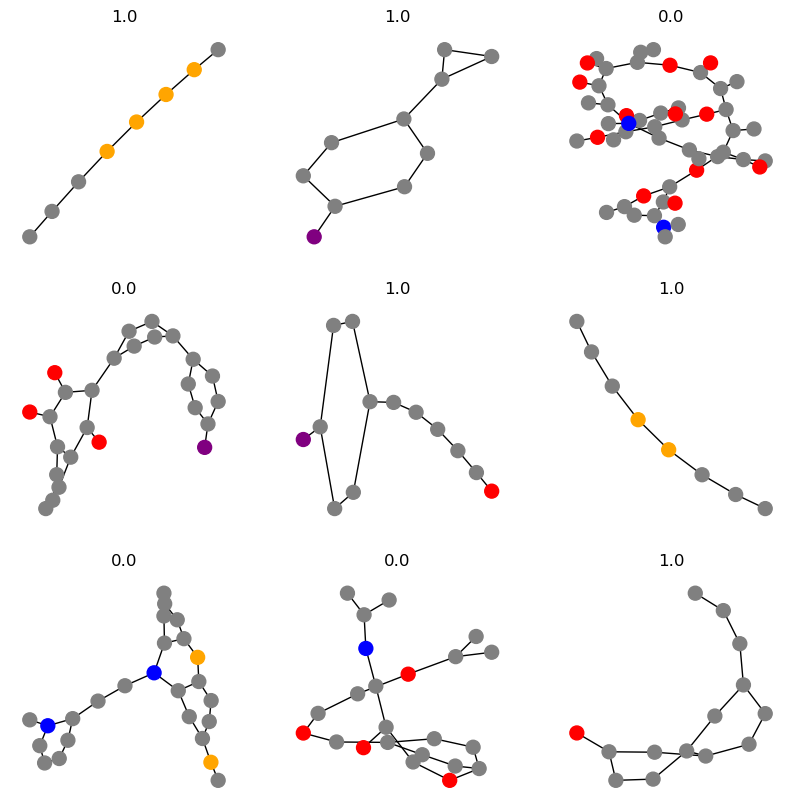

In [15]:

fig, axes = plt.subplots(3, 3, figsize=(10,10))
random_idx = np.random.randint(0, len(data_x), size=9)
for axis, i in zip(axes.flatten(), random_idx):

    # List of 1D arrays with two elements
    edges = list(edge_index[i].T) 

    # list of atoms letters
    nodes = [Chem.rdchem.Atom(int(atom_num)).GetSymbol() for atom_num in encoder.inverse_transform(data_x[i]).flatten()] 

    # label
    label = labels[i]

    # creating the graph
    G = nx.Graph()
    G.add_nodes_from([(i, {'atom':atom}) for i, atom in enumerate(nodes)])
    G.add_edges_from(edges)


    nx.draw(G, with_labels=False, ax=axis, node_color=[colors[a] for a in nodes], node_size=100)
    axis.set_title(label)